In [1]:
import matplotlib
#matplotlib.use('agg')

from ase.io import read,write
import ase.build
import numpy as np
from phonopy.structure.atoms import PhonopyAtoms
import API_phonopy as api_ph
import API_phonopy_lammps as api_pl
from phonopy import Phonopy
import phonopy.file_IO as PhonIO
from phonopy.interface.calculator import get_default_physical_units
import copy as cp
import os
import phonopy.interface.vasp as Intf_vasp 

import AllenFeldman as AF
from phonopy.interface.vasp import read_vasp,write_vasp
from hiphive import ForceConstants

import API_thirdorder as FC3
import thirdorder_core
import thirdorder_common
import subprocess
import h5py

- Storing the coefficients in a dense matrix
(3, 3, 3, 2, 54, 54)


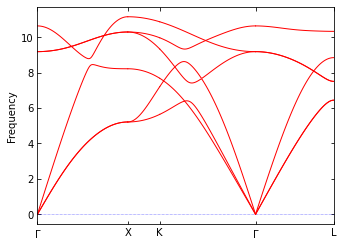

In [2]:
# Need to activate phono3py environment. 
Temperatures = [300]
a = 5.65414946767
Qpoints=np.array([[0.0001,0.0001,1.0],[0.5,0.5,1.0],[3./8,3./8,3./4],[0.0,0.0,0.0],[0.5,0.5,0.5]])
band_labels=['$\Gamma$','X','K','$\Gamma$','L']

Nrepeat=[3,3,3]
mesh = [7,7,7]
nneigh = 4 

poscar = 'POSCAR'

cmds = ["pair_style eim","pair_coeff * * Na Cl ffield.eim Na Cl"]

Band_points=100
NAC = True
interface_mode = 'vasp'


# compute FC2
prim_cell = Intf_vasp.read_vasp(poscar)
phonon = Phonopy(prim_cell,np.diag(Nrepeat))
phonon.generate_displacements(distance=0.03) # vasp
Scell0 = api_ph.phonopyAtoms_to_aseAtoms(phonon.get_supercell())

Scells_ph = phonon.get_supercells_with_displacements() # This returns a list of Phononpy atoms object

forces = api_pl.calc_lmp_force_sets(cmds,Scells_ph)
phonon.set_forces(forces)
PhonIO.write_FORCE_SETS(phonon.get_displacement_dataset()) # write forces & displacements to FORCE_SET
force_set=PhonIO.parse_FORCE_SETS() # parse force_sets
phonon.set_displacement_dataset(force_set) # force_set is a list of forces and displacements

if NAC == True:
    nac_params = PhonIO.get_born_parameters(
            open("BORN"),
            phonon.get_primitive(),
            phonon.get_primitive_symmetry())
    if nac_params['factor'] == None:
        physical_units = get_default_physical_units(interface_mode)
        nac_params['factor'] = physical_units['nac_factor']
    phonon._nac_params=nac_params


phonon.produce_force_constants()
phonon.symmetrize_force_constants()
api_ph.write_ShengBTE_FC2(phonon.get_force_constants(), filename='FORCE_CONSTANTS_2ND')
fc2 = phonon.get_force_constants() # get fc2.

# plot dispersion
bands=api_ph.qpoints_Band_paths(Qpoints,Band_points)
phonon.set_band_structure(bands,is_eigenvectors=True,labels=band_labels)
phonon.write_yaml_band_structure()
bs_plt=phonon.plot_band_structure()
bs_plt.xlabel("")
bs_plt.ylabel("Frequency (THz)",fontsize=16)
bs_plt.xticks(fontsize=16)
bs_plt.yticks(fontsize=16)
bs_plt.savefig("Bandstructure.png",dpi=300,bbox_inches='tight')


# compute FC3

poscar = FC3.read_POSCAR(".")
natoms = len(poscar["types"])
symops = thirdorder_core.SymmetryOperations(poscar["lattvec"], poscar["types"], poscar["positions"].T, 1e-5) # symops is an obj.
sposcar = FC3.gen_SPOSCAR(poscar, Nrepeat[0], Nrepeat[1], Nrepeat[2])
FC3.write_POSCAR(sposcar,'SPOSCAR')
ntot = natoms * np.prod(Nrepeat)
dmin, nequi, shifts = FC3.calc_dists(sposcar)
frange = FC3.calc_frange(poscar, sposcar, nneigh, dmin)


wedge = thirdorder_core.Wedge(poscar, sposcar, symops, dmin, nequi, shifts,frange)
list4 = wedge.build_list4()
nirred = len(list4)
nruns = 4 * nirred
width = len(str(4 * (len(list4) + 1)))
namepattern = "3RD.POSCAR.{{0:0{0}d}}".format(width)


Scells = []
phipart = np.zeros((3, nirred, ntot))
p = FC3.build_unpermutation(sposcar)
for i, e in enumerate(list4):
    for n in range(4): 
        isign = (-1)**(n // 2)
        jsign = -(-1)**(n % 2)
        # Start numbering the files at 1 for aesthetic
        # reasons.
        number = nirred * n + i + 1 # the number doesn't follow the order of 1,2,3,... 
        dsposcar = FC3.normalize_SPOSCAR(FC3.move_two_atoms(sposcar, e[1], e[3], isign * thirdorder_common.H, e[0], e[2], jsign * thirdorder_common.H))
        filename = namepattern.format(number)
        FC3.write_POSCAR(dsposcar, filename)
        Scell = read_vasp(filename)
        Scells.append(Scell)
        os.remove(filename)
        #print number
        Scell_ase = api_ph.phonopyAtoms_to_aseAtoms(Scell)
        force = np.array(api_pl.calc_lmp_force(cmds,Scell_ase))
        phipart[:, i, :] -= isign * jsign * force[p, :].T   
     
phipart /= (400. * thirdorder_common.H * thirdorder_common.H)
phifull = thirdorder_core.reconstruct_ifcs(phipart, wedge, list4,poscar, sposcar)
print(phifull.shape)
thirdorder_common.write_ifcs(phifull, poscar, sposcar, dmin, nequi, shifts, frange,"FORCE_CONSTANTS_3RD")

# convert FC3 shengBTE to fc3 for phono3py.
prim = read('POSCAR')
supercell = read('SPOSCAR')
fc3 = ForceConstants.read_shengBTE(supercell, 'FORCE_CONSTANTS_3RD', prim)

api_ph.write_phonopy_fc2_hdf5('fc2.hdf5',fc2)
api_ph.write_phonopy_fc3_hdf5('fc3.hdf5',fc3)

In [4]:
# run phono3py for phonon linewidths. 
phono3py_cmd = 'phono3py --dim="{} {} {}" --fc2 --fc3 --br --mesh="'\
               '{} {} {}" --ts="{}"'.format(Nrepeat[0],Nrepeat[1],Nrepeat[2], 
                                             mesh[0],mesh[1],mesh[2], ' '.join(str(T) for T in Temperatures))
subprocess.call(phono3py_cmd, shell=True)
qpoints,weights,freqs,gamma,kappaT = api_ph.read_phono3py_hdf5(mesh)
phonon.set_mesh(mesh)

        _                      _____
  _ __ | |__   ___  _ __   ___|___ / _ __  _   _
 | '_ \| '_ \ / _ \| '_ \ / _ \ |_ \| '_ \| | | |
 | |_) | | | | (_) | | | | (_) |__) | |_) | |_| |
 | .__/|_| |_|\___/|_| |_|\___/____/| .__/ \__, |
 |_|                                |_|    |___/ 
                                       2.3.2

Python version 3.9.12
Spglib version 1.16.2
----------------------------- General settings -----------------------------
Run mode: conductivity-RTA
HDF5 data compression filter: gzip
Crystal structure was read from "POSCAR".
Supercell (dim): [3 3 3]
Spacegroup: Fm-3m (225)
Use -v option to watch primitive cell, unit cell, and supercell structures.
----------------------------- Force constants ------------------------------
Imposing translational and index exchange symmetry to fc2: False
Imposing translational and index exchange symmetry to fc3: False
Reading fc3 from "fc3.hdf5".
Max drift of fc3: 0.000000 (zyz) 0.000000 (yzz) 0.000000 (yzz)
Reading fc2 from "f

Number of triplets: 100
Frequency     group velocity (x, y, z)     |gv|
   5.918   (   0.000   27.869    9.149)   29.333
   6.120   (  -0.000   36.265    8.050)   37.148
   7.941   (   0.000  -19.199    4.242)   19.662
   9.383   (   0.000  -28.110   -2.638)   28.234
  10.344   (   0.000    6.146    3.353)    7.001
  10.679   (   0.000   -5.419   20.801)   21.495
======================= Grid point 77 (20/20) =======================
q-point: (-0.29  0.43  0.14)
Boundary mean free path (millimetre): 1000.000
Number of triplets: 100
Frequency     group velocity (x, y, z)     |gv|
   6.440   (  14.188   30.802   -0.000)   33.913
   7.351   (   9.076  -24.937    0.000)   26.537
   7.690   ( -24.451   34.431   -0.000)   42.230
   8.364   (   2.899  -40.074    0.000)   40.179
  10.346   (  16.619    6.665   -0.000)   17.905
  10.721   (   3.302   -7.831    0.000)    8.499
=================== End of collection of collisions ===================
----------- Thermal conductivity (W/m-k) with tetr

In [ ]:
# under construction, compute QHGK thermal conductivity
for iq,q in enumerate(qpoints):
    weight_q = weights[iq]
    freqs_q = freqs[iq]
    gamma_q = gamma[0][iq]
    vx_mp_q,vy_mp_q,vz_mp_q = AF.get_velmat_modepairs_q(phonon,q)
    #calc_Diff_TrueLineWidth(freqs_q,vx_mp_q,vy_mp_q,vz_mp_q,gamma

In [ ]:
ph3_data = h5py.File('kappa-m{}{}{}.hdf5'.format(mesh[0],mesh[1],mesh[2]),'r')